This notebook compares different approaches to solving the maximum clique problem:
1. Traditional Algorithms (KNN, ACO, Local Search, Greedy, Annealing)
2. DNA-inspired Evolutionary Algorithm
3. Performance Comparison on Random Networks

## Imports

In [ ]:
!pip install dwave-greedy
!pip install dimod
!pip install dwave-neal
!pip install dwave-greedy
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 89.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
from functools import lru_cache
import random
import itertools
from typing import List, Set, Tuple
import seaborn as sns
import pandas as pd

import dimod
import neal
import greedy
import networkx as nx
from networkx import make_max_clique_graph
from networkx.algorithms.approximation import clique
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

## Base class

In [ ]:
class Graph:
    """Base class for graph operations"""

    def __init__(self, adj_matrix: np.ndarray):
        """
        Initialize graph from adjacency matrix

        Parameters:
        -----------
        adj_matrix : np.ndarray
            Symmetric adjacency matrix representing an undirected graph
        """
        self.adj_matrix = np.array(adj_matrix)
        self.num_vertices = len(adj_matrix)
        self.validate_matrix()

    def validate_matrix(self):
        """Validate the adjacency matrix properties"""
        if self.adj_matrix.shape[0] != self.adj_matrix.shape[1]:
            raise ValueError("Adjacency matrix must be square")
        if not np.array_equal(self.adj_matrix, self.adj_matrix.T):
            raise ValueError("Adjacency matrix must be symmetric")
        if not np.array_equal(np.diag(self.adj_matrix), np.zeros(self.num_vertices)):
            raise ValueError("Adjacency matrix diagonal must be zero")

    def density(self) -> float:
        """Calculate graph density"""
        return np.sum(self.adj_matrix) / (self.num_vertices * (self.num_vertices - 1))

    def degree(self, vertex: int) -> int:
        """Calculate degree of a vertex"""
        return np.sum(self.adj_matrix[vertex])

    def is_clique(self, vertices: List[int]) -> bool:
        """Check if given vertices form a clique"""
        for i in vertices:
            for j in vertices:
                if i != j and self.adj_matrix[i, j] == 0:
                    return False
        return True

class GraphGenerator:
    """Class for generating random graphs"""

    @staticmethod
    def random_graph(num_vertices: int, density: float) -> Graph:
        """
        Generate random graph with given number of vertices and density

        Parameters:
        -----------
        num_vertices : int
            Number of vertices in the graph
        density : float
            Desired edge density (between 0 and 1)

        Returns:
        --------
        Graph
            Generated random graph
        """
        # Generate upper triangle
        adj_matrix = np.random.choice(
            [0, 1],
            size=(num_vertices, num_vertices),
            p=[1-density, density]
        )
        # Make symmetric
        adj_matrix = np.triu(adj_matrix, 1)
        adj_matrix = adj_matrix + adj_matrix.T
        # Set diagonal to 0
        np.fill_diagonal(adj_matrix, 0)

        return Graph(adj_matrix)

class MaxCliqueResult:
    """Class to store and compare maximum clique results"""

    def __init__(self, vertices: List[int], execution_time: float):
        self.vertices = vertices
        self.size = len(vertices)
        self.execution_time = execution_time

    def __str__(self):
        return f"Clique size: {self.size}, Time: {self.execution_time:.4f}s"

    def to_dict(self):
        return {
            'size': self.size,
            'time': self.execution_time,
            'vertices': self.vertices
        }

def benchmark_algorithm(func):
    """Decorator to measure execution time of algorithms"""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        execution_time = time.time() - start_time
        if isinstance(result, (list, np.ndarray)):
            return MaxCliqueResult(list(result), execution_time)
        return result
    return wrapper

## Non-evolutionary Algorithms for Solving Max Clique

In [ ]:
class MaxCliqueTraditional:
    """Implementation of traditional maximum clique algorithms"""

    def __init__(self, graph: Graph):
        """
        Initialize solver with a graph

        Parameters:
        -----------
        graph : Graph
            Graph instance to find maximum clique in
        """
        self.graph = graph
        self.adj_matrix = graph.adj_matrix
        self.num_vertices = graph.num_vertices

    @benchmark_algorithm
    def knn_solve(self, k: int = None) -> List[int]:
        """KNN-based maximum clique algorithm"""
        # If k is not specified, use average degree
        if k is None:
            k = int(np.mean(np.sum(self.adj_matrix, axis=1)))

        # Create feature matrix
        features = []
        for i in range(self.num_vertices):
            degree = np.sum(self.adj_matrix[i])
            neighbors = set(np.where(self.adj_matrix[i] == 1)[0])
            feature_vec = [degree, len(neighbors)]
            features.append(feature_vec)

        features = np.array(features)

        # Find k-nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=min(k+1, self.num_vertices))
        nbrs.fit(features)
        distances, indices = nbrs.kneighbors(features)

        best_clique = []
        for i in range(self.num_vertices):
            neighbors = indices[i][1:]  # Exclude the vertex itself
            potential_clique = {i}

            for neighbor in neighbors:
                if all(self.adj_matrix[neighbor, member] == 1
                      for member in potential_clique):
                    potential_clique.add(neighbor)

            if len(potential_clique) > len(best_clique):
                best_clique = list(potential_clique)

        return best_clique

    @benchmark_algorithm
    def local_search_solve(self, max_iterations: int = 100,
                          time_limit: float = 30.0) -> List[int]:
        """Local search (previously called LKH) maximum clique algorithm"""
        start_time = time.time()

        def find_best_vertex_to_add(current_clique: Set[int]) -> int:
            candidates = []
            for v in range(self.num_vertices):
                if v not in current_clique:
                    if all(self.adj_matrix[v][u] for u in current_clique):
                        candidates.append((v, sum(self.adj_matrix[v])))
            return max(candidates, key=lambda x: x[1])[0] if candidates else -1

        def find_best_vertex_to_remove(current_clique: Set[int]) -> int:
            best_vertex = -1
            best_improvement = -1
            vertices_to_check = sorted(current_clique,
                                     key=lambda x: sum(self.adj_matrix[x]))[:3]

            for v in vertices_to_check:
                temp_clique = current_clique - {v}
                potential_additions = sum(
                    1 for u in range(self.num_vertices)
                    if u not in temp_clique and
                    all(self.adj_matrix[u][w] for w in temp_clique)
                )

                if potential_additions > best_improvement:
                    best_vertex = v
                    best_improvement = potential_additions

            return best_vertex if best_improvement > 0 else -1

        # Initialize with greedy approach
        current_clique = set()
        vertices_by_degree = sorted(range(self.num_vertices),
                                  key=lambda x: sum(self.adj_matrix[x]),
                                  reverse=True)

        current_clique.add(vertices_by_degree[0])
        for v in vertices_by_degree[1:]:
            if all(self.adj_matrix[v][u] for u in current_clique):
                current_clique.add(v)

        best_clique = set(current_clique)
        no_improvement = 0
        iterations = 0

        while no_improvement < max_iterations and iterations < max_iterations:
            if time.time() - start_time > time_limit:
                break

            iterations += 1
            improved = False
            vertex_to_remove = find_best_vertex_to_remove(current_clique)

            if vertex_to_remove != -1:
                current_clique.remove(vertex_to_remove)
                add_attempts = 0
                while add_attempts < 5:
                    vertex_to_add = find_best_vertex_to_add(current_clique)
                    if vertex_to_add == -1:
                        break
                    current_clique.add(vertex_to_add)
                    improved = True
                    add_attempts += 1

            if len(current_clique) > len(best_clique) and self.graph.is_clique(list(current_clique)):
                best_clique = set(current_clique)
                improved = True
                no_improvement = 0
            else:
                no_improvement += 1

            if no_improvement > 10:
                current_clique = {random.choice(vertices_by_degree[:5])}
                for v in vertices_by_degree:
                    if all(self.adj_matrix[v][u] for u in current_clique):
                        current_clique.add(v)
                no_improvement = 0

        return list(best_clique)

    @benchmark_algorithm
    def ant_colony_solve(self, n_ants: int = 20, n_iterations: int = 50,
                        evaporation_rate: float = 0.1, alpha: float = 1.0,
                        beta: float = 2.0) -> List[int]:
        """Ant Colony Optimization for maximum clique"""
        # Initialize pheromone matrix
        pheromone = np.ones((self.num_vertices, self.num_vertices))
        heuristic = np.sum(self.adj_matrix, axis=1)
        best_clique = []

        for iteration in range(n_iterations):
            iteration_cliques = []

            for ant in range(n_ants):
                current_clique = set()
                available_vertices = set(range(self.num_vertices))

                current_vertex = random.choice(list(available_vertices))
                current_clique.add(current_vertex)
                available_vertices.remove(current_vertex)

                available_vertices = {v for v in available_vertices
                                   if all(self.adj_matrix[v][u] for u in current_clique)}

                while available_vertices:
                    probabilities = []
                    for v in available_vertices:
                        avg_pheromone = np.mean([pheromone[v][u] for u in current_clique])
                        prob = (avg_pheromone ** alpha) * (heuristic[v] ** beta)
                        probabilities.append(prob)

                    probabilities = np.array(probabilities)
                    probabilities = probabilities / np.sum(probabilities)

                    next_vertex = random.choices(list(available_vertices),
                                              weights=probabilities, k=1)[0]

                    current_clique.add(next_vertex)
                    available_vertices.remove(next_vertex)
                    available_vertices = {v for v in available_vertices
                                       if all(self.adj_matrix[v][u]
                                            for u in current_clique)}

                iteration_cliques.append(list(current_clique))

            current_best = max(iteration_cliques, key=len)
            if len(current_best) > len(best_clique):
                best_clique = current_best

            pheromone *= (1 - evaporation_rate)

            for clique in iteration_cliques:
                deposit = len(clique) / self.num_vertices
                for i in clique:
                    for j in clique:
                        if i != j:
                            pheromone[i][j] += deposit

        return best_clique

    @benchmark_algorithm
    def qubo_solve(self, method='GREEDY', num_reads=100,
                   seed=None, **kwargs) -> List[int]:
        """QUBO-based maximum clique algorithm"""
        # Prepare QUBO matrix
        G = nx.from_numpy_array(self.adj_matrix)
        problem_size = G.number_of_nodes()
        lmbda = problem_size

        # Get complement of graph for QUBO formulation
        complement_adj = np.array(nx.to_numpy_array(nx.complement(G)))
        Q_matrix = complement_adj * (lmbda/2)

        # Set diagonal terms
        for i in range(problem_size):
            Q_matrix[i,i] = -1

        # Solve using specified method
        solution = self._solve_qubo(Q_matrix, method=method,
                                  num_reads=num_reads, seed=seed, **kwargs)

        # Convert solution to vertex list
        vertices = [i for i, x in enumerate(solution) if x]
        return vertices

    def _solve_qubo(self, Q_matrix, method='GREEDY', num_reads=100,
                    seed=None, **kwargs):
        """Helper method for solving QUBO problems"""
        if method == 'DEXACT':
            solution, _ = self._brute_qubo_solver(Q_matrix)
        elif method == 'NEAL':
            solution, _ = self._annealer_qubo_solver(Q_matrix, num_reads=num_reads,
                                                   seed=seed, **kwargs)
        elif method == 'GREEDY':
            solution, _ = self._greedy_qubo_solver(Q_matrix, num_reads=num_reads,
                                                 seed=seed, **kwargs)
        else:
            raise ValueError(f'Invalid method: {method}')
        return solution

    def _brute_qubo_solver(self, Q_matrix, offset=0):
        model = dimod.BQM(Q_matrix, "BINARY", offset=offset)
        response = dimod.ExactSolver().sample(model)
        return (np.fromiter(response.first.sample.values(), dtype=int),
                response.first.energy)

    def _annealer_qubo_solver(self, Q_matrix, offset=0, num_reads=1,
                             seed=None, **kwargs):
        model = dimod.BQM(Q_matrix, "BINARY", offset=offset)
        response = neal.SimulatedAnnealingSampler().sample(
            model, num_reads=num_reads, seed=seed, **kwargs)
        return (np.fromiter(response.first.sample.values(), dtype=int),
                response.first.energy)

    def _greedy_qubo_solver(self, Q_matrix, offset=0, num_reads=1,
                           seed=None, **kwargs):
        model = dimod.BQM(Q_matrix, "BINARY", offset=offset)
        response = greedy.SteepestDescentSampler().sample(
            model, num_reads=num_reads, seed=seed, **kwargs)
        return (np.fromiter(response.first.sample.values(), dtype=int),
                response.first.energy)

## DNA Inspired Evolutionary Method for Max Clique Problem

In [ ]:
class CompressedDNANeuron:
    """Represents a vertex in the graph with epigenetic properties"""

    def __init__(self, vertex_index: int):
        self.vertex_index = vertex_index
        self.epigenetic_tags = {
            'mutation_resistance': np.random.random(),  # Resistance to being removed
            'crossover_affinity': np.random.random(),   # Likelihood to be preserved
            'stability_score': np.random.random()       # Tracks success in cliques
        }

class CompressedDNAMaxClique:
    """DNA-inspired solution representation for maximum clique problem"""

    def __init__(self, graph: Graph, subpop_id: int = 0):
        """
        Initialize a DNA-inspired solution

        Parameters:
        -----------
        graph : Graph
            Graph to find maximum clique in
        subpop_id : int
            Identifier for the subpopulation this solution belongs to
        """
        self.graph = graph
        self.adj_matrix = graph.adj_matrix
        self.num_vertices = graph.num_vertices
        self.subpop_id = subpop_id

        # Initialize with high-degree vertices
        degrees = np.sum(self.adj_matrix, axis=1)
        probabilities = degrees / np.sum(degrees)
        num_initial = max(3, self.num_vertices // 10)
        selected = np.random.choice(self.num_vertices, size=num_initial,
                                  p=probabilities, replace=False)

        self.neurons = [CompressedDNANeuron(i) for i in selected]
        self.needs_improvement = True
        self.last_improvement = 0

    def get_vertices(self) -> List[int]:
        """Get current vertex set"""
        return [n.vertex_index for n in self.neurons]

    def update_epigenetic_tags(self, was_successful: bool):
        """Update epigenetic tags based on success"""
        if was_successful:
            for neuron in self.neurons:
                neuron.epigenetic_tags['stability_score'] = min(
                    1.0, neuron.epigenetic_tags['stability_score'] + 0.1)
                neuron.epigenetic_tags['mutation_resistance'] = min(
                    1.0, neuron.epigenetic_tags['mutation_resistance'] + 0.05)
        else:
            for neuron in self.neurons:
                neuron.epigenetic_tags['stability_score'] = max(
                    0.0, neuron.epigenetic_tags['stability_score'] - 0.1)
                neuron.epigenetic_tags['mutation_resistance'] = max(
                    0.0, neuron.epigenetic_tags['mutation_resistance'] - 0.05)

    def improve_clique(self) -> List[int]:
        """Improve current solution to ensure and maximize clique property"""
        initial_vertices = set(self.get_vertices())
        vertices = list(initial_vertices)

        # Ensure valid clique
        changed = True
        while changed:
            changed = False
            for v in vertices[:]:
                for u in vertices:
                    if v != u and self.adj_matrix[v][u] == 0:
                        vertices.remove(v)
                        changed = True
                        break

        valid_clique = set(vertices)
        was_successful = len(valid_clique) >= len(initial_vertices)
        self.update_epigenetic_tags(was_successful)

        # Try to expand using graph properties
        degrees = np.sum(self.adj_matrix, axis=1)
        candidates = []
        for v in range(self.num_vertices):
            if v not in valid_clique:
                if all(self.adj_matrix[v][u] for u in valid_clique):
                    candidates.append((v, degrees[v]))

        # Add candidates sorted by degree
        for v, _ in sorted(candidates, key=lambda x: x[1], reverse=True):
            if all(self.adj_matrix[v][u] for u in valid_clique):
                valid_clique.add(v)

        self.neurons = [CompressedDNANeuron(v) for v in valid_clique]
        self.needs_improvement = False
        return list(valid_clique)

    def mutate(self):
        """Apply mutation operator"""
        if len(self.neurons) < 2:
            return

        self.needs_improvement = True
        mutation_type = np.random.choice(['swap', 'insert', 'remove', 'local_search'])

        if mutation_type == 'swap':
            self._swap_mutation()
        elif mutation_type == 'insert':
            self._insert_mutation()
        elif mutation_type == 'remove':
            self._remove_mutation()
        else:  # local_search
            self._local_search_mutation()

    def _swap_mutation(self):
        """Swap two vertices"""
        if len(self.neurons) >= 2:
            i, j = np.random.choice(len(self.neurons), 2, replace=False)
            self.neurons[i], self.neurons[j] = self.neurons[j], self.neurons[i]

    def _insert_mutation(self):
        """Insert new vertex"""
        current_vertices = set(self.get_vertices())
        candidates = []
        for v in range(self.num_vertices):
            if v not in current_vertices:
                if all(self.adj_matrix[v][u] for u in current_vertices):
                    candidates.append(v)

        if candidates:
            degrees = np.array([np.sum(self.adj_matrix[v]) for v in candidates])
            probs = degrees / degrees.sum()
            new_vertex = np.random.choice(candidates, p=probs)
            new_neuron = CompressedDNANeuron(new_vertex)
            new_neuron.epigenetic_tags['crossover_affinity'] = 0.7
            self.neurons.append(new_neuron)

    def _remove_mutation(self):
        """Remove vertex with lowest degree"""
        if len(self.neurons) > 2:
            vertex_degrees = [(i, np.sum(self.adj_matrix[n.vertex_index]))
                            for i, n in enumerate(self.neurons)]
            idx_to_remove = min(vertex_degrees, key=lambda x: x[1])[0]
            self.neurons.pop(idx_to_remove)

    def _local_search_mutation(self):
        current_vertices = set(self.get_vertices())
        for v in range(self.num_vertices):
            if v not in current_vertices:
                if all(self.adj_matrix[v][u] for u in current_vertices):
                    self.neurons.append(CompressedDNANeuron(v))
                    break

    def fitness(self) -> Tuple[int, List[int]]:
        """Calculate fitness (clique size) and return solution"""
        vertices = self.improve_clique()
        return len(vertices), vertices

    @classmethod
    def crossover(cls, parent1: 'CompressedDNAMaxClique',
                 parent2: 'CompressedDNAMaxClique') -> 'CompressedDNAMaxClique':
        child = cls(parent1.graph)

        parent1_vertices = set(parent1.get_vertices())
        parent2_vertices = set(parent2.get_vertices())
        common_vertices = parent1_vertices & parent2_vertices

        child.neurons = []
        # Add common vertices that maintain clique property
        for v in common_vertices:
            if all(parent1.adj_matrix[v][u] for u in [n.vertex_index for n in child.neurons]):
                child.neurons.append(CompressedDNANeuron(v))

        # Try to add remaining vertices
        remaining = list(parent1_vertices | parent2_vertices - common_vertices)
        np.random.shuffle(remaining)

        for v in remaining:
            if all(parent1.adj_matrix[v][u] for u in [n.vertex_index for n in child.neurons]):
                child.neurons.append(CompressedDNANeuron(v))

        child.needs_improvement = True
        return child

class EvolutionaryOptimizer:
    """Manages the evolutionary process for finding maximum cliques"""

    def __init__(self, graph: Graph, pop_size: int = 50, num_subpops: int = 5,
                 generations: int = 200, early_stopping_generations: int = 20):
        """
        Initialize the evolutionary optimizer

        Parameters:
        -----------
        graph : Graph
            Graph to find maximum clique in
        pop_size : int
            Population size
        num_subpops : int
            Number of subpopulations
        generations : int
            Maximum number of generations
        early_stopping_generations : int
            Number of generations without improvement before stopping
        """
        self.graph = graph
        self.pop_size = pop_size
        self.num_subpops = num_subpops
        self.generations = generations
        self.early_stopping_generations = early_stopping_generations

    def process_individual(self, network: CompressedDNAMaxClique) -> Tuple[int, CompressedDNAMaxClique]:
        mutation_rate = 0.2 * (1.0 + network.last_improvement / 10)
        if np.random.random() < mutation_rate:
            network.mutate()

        if network.needs_improvement:
            old_size = len(network.get_vertices())
            network.improve_clique()
            new_size = len(network.get_vertices())
            network.last_improvement = new_size - old_size

        return network.fitness()[0], network

    def horizontal_gene_transfer(self, subpopulations: List[List[CompressedDNAMaxClique]]):
        for i, subpop1 in enumerate(subpopulations):
            for j, subpop2 in enumerate(subpopulations):
                if i != j:
                    fitness1 = np.mean([ind.fitness()[0] for ind in subpop1])
                    fitness2 = np.mean([ind.fitness()[0] for ind in subpop2])

                    source_pop = subpop1 if fitness1 > fitness2 else subpop2
                    target_pop = subpop2 if fitness1 > fitness2 else subpop1

                    for source_ind in source_pop:
                        for target_ind in target_pop:
                            if np.random.random() < 0.1:
                                source_vertices = set(source_ind.get_vertices())
                                target_vertices = set(target_ind.get_vertices())
                                common = source_vertices & target_vertices
                                if common:
                                    target_ind.neurons = [
                                        CompressedDNANeuron(v) for v in common]
                                    target_ind.needs_improvement = True

    def evolve(self) -> CompressedDNAMaxClique:
        # Initialize subpopulations
        subpopulations = [
            [CompressedDNAMaxClique(self.graph, subpop_id=i)
             for _ in range(self.pop_size // self.num_subpops)]
            for i in range(self.num_subpops)
        ]

        best_fitness = 0
        best_fitness_count = 0
        best_solution = None
        generation_without_improvement = 0

        # Create pool here instead
        with Pool(processes=cpu_count()) as pool:
            for gen in range(self.generations):
                # Process each subpopulation
                for subpop in subpopulations:
                    fitnesses_and_networks = pool.map(
                        self.process_individual, subpop)
                    sorted_population = sorted(
                        fitnesses_and_networks, key=lambda x: x[0], reverse=True)
                    subpop[:] = [network for _, network in sorted_population]

                    # Check diversity
                    unique_solutions = len(set(
                        tuple(ind.get_vertices()) for ind in subpop))
                    if unique_solutions < len(subpop) * 0.5:
                        new_solutions = [
                            CompressedDNAMaxClique(self.graph)
                            for _ in range(len(subpop)//4)
                        ]
                        subpop.extend(new_solutions)
                        subpop.sort(key=lambda x: x.fitness()[0], reverse=True)
                        subpop = subpop[:self.pop_size // self.num_subpops]

                # Horizontal gene transfer
                if gen % 5 == 0:
                    self.horizontal_gene_transfer(subpopulations)

                # Update best solution
                current_best_fitness = max(
                    subpop[0].fitness()[0] for subpop in subpopulations)
                if current_best_fitness > best_fitness:
                    best_fitness = current_best_fitness
                    best_fitness_count = 0
                    best_solution = max(
                        (subpop[0] for subpop in subpopulations),
                        key=lambda x: x.fitness()[0])
                else:
                    best_fitness_count += 1

                if best_fitness_count >= self.early_stopping_generations:
                    print(f"Early stopping at generation {gen}")
                    break

                # Evolution step
                self._evolution_step(subpopulations, generation_without_improvement)

        return best_solution

    def _evolution_step(self, subpopulations: List[List[CompressedDNAMaxClique]],
                       generation_without_improvement: int):
        for subpop in subpopulations:
            elite_size = max(1, len(subpop) // 10)
            new_population = list(subpop[:elite_size])

            crossover_rate = 0.7 * (1.0 - generation_without_improvement / self.generations)

            while len(new_population) < len(subpop):
                if np.random.random() < crossover_rate:
                    tournament_size = min(5, len(subpop))
                    parent1 = max(np.random.choice(subpop, tournament_size),
                                key=lambda x: x.fitness()[0])
                    parent2 = max(np.random.choice(subpop, tournament_size),
                                key=lambda x: x.fitness()[0])
                    child = CompressedDNAMaxClique.crossover(parent1, parent2)
                else:
                    child = CompressedDNAMaxClique(self.graph)

                new_population.append(child)

            subpop[:] = new_population

In [ ]:
class BenchmarkRunner:
    """Optimized framework for running algorithm comparisons"""

    def __init__(self, num_trials: int = 5, density: float = 0.3):
        self.num_trials = num_trials
        self.density = density
        self.graph_sizes = [10, 25, 50, 100, 200]
        self.population_sizes = [10, 25]

        # Algorithm configurations
        self.aco_config = {
            'n_ants': 10,      # Reduced from 20
            'n_iterations': 25  # Reduced from 50
        }
        self.evolutionary_config = {
            'generations': 100,  # Reduced from 200
            'early_stopping_generations': 10  # Reduced from 20
        }

    def run_benchmarks(self) -> pd.DataFrame:
        """Run complete benchmark suite with optimizations"""
        all_results = []

        # Generate all graphs first
        print("Generating test graphs...")
        test_graphs = {
            size: [GraphGenerator.random_graph(size, self.density)
                  for _ in range(self.num_trials)]
            for size in self.graph_sizes
        }

        # Run algorithms one by one across all graphs
        print("\nRunning KNN...")
        self._run_knn(test_graphs, all_results)

        print("\nRunning Local Search...")
        self._run_local_search(test_graphs, all_results)

        print("\nRunning ACO...")
        self._run_aco(test_graphs, all_results)

        print("\nRunning QUBO-Greedy...")
        self._run_qubo(test_graphs, all_results, method='GREEDY')

        print("\nRunning QUBO-Annealer...")
        self._run_qubo(test_graphs, all_results, method='NEAL')

        print("\nRunning Evolutionary...")
        self._run_evolutionary(test_graphs, all_results)

        # Convert to DataFrame and format
        final_df = pd.DataFrame(all_results)
        # print results
        return final_df

    def _run_knn(self, graphs, results):
        for size in tqdm(self.graph_sizes):
            for trial, graph in enumerate(graphs[size]):
                solver = MaxCliqueTraditional(graph)
                result = solver.knn_solve()
                self._add_result(results, size, trial, 'KNN', result)

    def _run_local_search(self, graphs, results):
        for size in tqdm(self.graph_sizes):
            for trial, graph in enumerate(graphs[size]):
                solver = MaxCliqueTraditional(graph)
                result = solver.local_search_solve(max_iterations=50, time_limit=15.0)
                self._add_result(results, size, trial, 'Local Search', result)

    def _run_aco(self, graphs, results):
        for size in tqdm(self.graph_sizes):
            for trial, graph in enumerate(graphs[size]):
                solver = MaxCliqueTraditional(graph)
                result = solver.ant_colony_solve(**self.aco_config)
                self._add_result(results, size, trial, 'ACO', result)

    def _run_qubo(self, graphs, results, method):
        for size in tqdm(self.graph_sizes):
            for trial, graph in enumerate(graphs[size]):
                solver = MaxCliqueTraditional(graph)
                result = solver.qubo_solve(method=method)
                self._add_result(results, size, trial, f'QUBO-{method}', result)

    def _run_evolutionary(self, graphs, results):
        for size in tqdm(self.graph_sizes):
            for pop_size in self.population_sizes:
                print(f"\nTesting population size: {pop_size} for graph size: {size}")
                for trial, graph in enumerate(graphs[size]):
                    optimizer = EvolutionaryOptimizer(
                        graph=graph,
                        pop_size=pop_size,
                        **self.evolutionary_config
                    )

                    start_time = time.time()
                    best_solution = optimizer.evolve()
                    execution_time = time.time() - start_time

                    clique_size, clique_vertices = best_solution.fitness()
                    results.append({
                        'Graph_Size': size,
                        'Trial': trial,
                        'Algorithm': 'Evolutionary',
                        'Population_Size': pop_size,
                        'Clique_Size': clique_size,
                        'Time': execution_time,
                        'Valid': graph.is_clique(clique_vertices)
                    })

    def _add_result(self, results, size, trial, algo, result):
        """Helper method to add result to results list"""
        results.append({
            'Graph_Size': size,
            'Trial': trial,
            'Algorithm': algo,
            'Population_Size': 'N/A',
            'Clique_Size': result.size,
            'Time': result.execution_time,
            'Valid': result.size > 0
        })

### Run benchmarks

In [ ]:
def print_formatted_results(df: pd.DataFrame):
    print("\n" + "="*100)
    print("BENCHMARK RESULTS SUMMARY")
    print("="*100)

    # Format for traditional algorithms
    print("\nTraditional Algorithms Results:")
    print("-"*100)
    trad_results = df[df.index.get_level_values('Population_Size') == 'N/A']
    print(f"{'Graph Size':<10} {'Algorithm':<15} {'Best Clique Size':<20} "
          f"{'Avg Time (s)':<15} {'Time Std Dev':<15} {'Valid %':<10}")
    print("-"*100)

    for idx in trad_results.index:
        size, algo, _ = idx
        row = trad_results.loc[idx]
        print(f"{size:<10} {algo:<15} {row['Clique_Size_max']:<20d} "
              f"{row['Time_mean']:<15.2f} {row['Time_std']:<15.2f} "
              f"{row['Valid']*100:<10.1f}%")

    # Format for evolutionary algorithm with different population sizes
    print("\nEvolutionary Algorithm Results:")
    print("-"*100)
    evo_results = df[df.index.get_level_values('Population_Size') != 'N/A']
    print(f"{'Graph Size':<10} {'Pop Size':<10} {'Best Clique Size':<20} "
          f"{'Avg Time (s)':<15} {'Time Std Dev':<15} {'Valid %':<10}")
    print("-"*100)

    for idx in evo_results.index:
        size, algo, pop_size = idx
        if algo == 'Evolutionary':
            row = evo_results.loc[idx]
            print(f"{size:<10} {pop_size:<10} {row['Clique_Size_max']:<20d} "
                  f"{row['Time_mean']:<15.2f} {row['Time_std']:<15.2f} "
                  f"{row['Valid']*100:<10.1f}%")

def create_benchmark_plots(df: pd.DataFrame):
    plt.style.use('seaborn')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot best clique sizes instead of averages
    ax1.set_title('Best Maximum Clique Size Found by Graph Size', pad=20)
    ax1.set_xlabel('Graph Size')
    ax1.set_ylabel('Best Clique Size')

    trad_results = df[df.index.get_level_values('Population_Size') == 'N/A']
    evo_results = df[df.index.get_level_values('Population_Size') != 'N/A']

    # Plot traditional algorithms
    for algo in trad_results.index.get_level_values('Algorithm').unique():
        data = trad_results.xs(algo, level='Algorithm')
        ax1.plot(data.index.get_level_values('Graph_Size'),
                data['Clique_Size_max'],
                label=algo,
                marker='o')

    # Plot evolutionary algorithm for each population size
    for pop_size in evo_results.index.get_level_values('Population_Size').unique():
        data = evo_results.xs(('Evolutionary', pop_size),
                            level=['Algorithm', 'Population_Size'])
        ax1.plot(data.index,
                data['Clique_Size_max'],
                label=f'Evolutionary (pop={pop_size})',
                marker='s')

    ax1.grid(True)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Time plot remains the same
    ax2.set_title('Average Execution Time by Graph Size', pad=20)
    ax2.set_xlabel('Graph Size')
    ax2.set_ylabel('Average Time (seconds)')
    ax2.set_yscale('log')

    for algo in trad_results.index.get_level_values('Algorithm').unique():
        data = trad_results.xs(algo, level='Algorithm')
        ax2.errorbar(data.index.get_level_values('Graph_Size'),
                    data['Time_mean'],
                    yerr=data['Time_std'],
                    label=algo,
                    marker='o')

    for pop_size in evo_results.index.get_level_values('Population_Size').unique():
        data = evo_results.xs(('Evolutionary', pop_size),
                            level=['Algorithm', 'Population_Size'])
        ax2.errorbar(data.index,
                    data['Time_mean'],
                    yerr=data['Time_std'],
                    label=f'Evolutionary (pop={pop_size})',
                    marker='s')

    ax2.grid(True)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
benchmark = BenchmarkRunner(num_trials=5, density=0.3)
results = benchmark.run_benchmarks()
# results.to_csv('benchmark_results.csv')

Generating test graphs...

Running KNN...


100%|██████████| 5/5 [00:00<00:00, 17.91it/s]



Running Local Search...


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]



Running ACO...


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]



Running QUBO-Greedy...


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]



Running QUBO-Annealer...


100%|██████████| 5/5 [00:20<00:00,  4.01s/it]



Running Evolutionary...


  0%|          | 0/5 [00:00<?, ?it/s]


Testing population size: 10 for graph size: 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10

Testing population size: 25 for graph size: 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10


 20%|██        | 1/5 [00:05<00:20,  5.18s/it]

Early stopping at generation 10

Testing population size: 10 for graph size: 25
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10

Testing population size: 25 for graph size: 25
Early stopping at generation 10
Early stopping at generation 11
Early stopping at generation 10
Early stopping at generation 10


 40%|████      | 2/5 [00:09<00:13,  4.56s/it]

Early stopping at generation 10

Testing population size: 10 for graph size: 50
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10

Testing population size: 25 for graph size: 50
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10


 60%|██████    | 3/5 [00:14<00:09,  4.83s/it]

Early stopping at generation 10

Testing population size: 10 for graph size: 100
Early stopping at generation 10
Early stopping at generation 15
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10

Testing population size: 25 for graph size: 100
Early stopping at generation 13
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10


 80%|████████  | 4/5 [00:25<00:07,  7.14s/it]

Early stopping at generation 10

Testing population size: 10 for graph size: 200
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 10
Early stopping at generation 12

Testing population size: 25 for graph size: 200
Early stopping at generation 10
Early stopping at generation 11
Early stopping at generation 10
Early stopping at generation 18


100%|██████████| 5/5 [00:52<00:00, 10.45s/it]

Early stopping at generation 10


In [ ]:
results = pd.read_csv('benchmark_results.csv')

In [ ]:
results

,Graph_Size,Trial,Algorithm,Population_Size,Clique_Size,Time,Valid
0,10,0,KNN,N/A,2,0.004358,True
1,10,1,KNN,N/A,2,0.001940,True
2,10,2,KNN,N/A,2,0.001746,True
3,10,3,KNN,N/A,3,0.001678,True
4,10,4,KNN,N/A,2,0.001744,True
...,...,...,...,...,...,...,...
170,200,0,Evolutionary,25,6,6.485832,True
171,200,1,Evolutionary,25,7,5.391321,True
172,200,2,Evolutionary,25,6,1.714427,True
173,200,3,Evolutionary,25,7,8.262528,True


In [ ]:
def create_formatted_results_table(results_df: pd.DataFrame):
    """Create nicely formatted table with all algorithms"""
    # Create basic table as before
    graph_sizes = sorted(results_df['Graph_Size'].unique())
    table_dict = {'Graph_Size': graph_sizes}

    # Handle traditional algorithms
    trad_algos = results_df[
        results_df['Population_Size'].isna()
    ]['Algorithm'].unique()

    # Add traditional algorithms
    for algo in trad_algos:
        max_cliques = []
        for size in graph_sizes:
            clique_size = results_df[
                (results_df['Algorithm'] == algo) &
                (results_df['Graph_Size'] == size)
            ]['Clique_Size'].max()
            max_cliques.append(clique_size)
        table_dict[algo] = max_cliques

    # Add evolutionary results
    evo_pop_sizes = results_df[
        results_df['Algorithm'] == 'Evolutionary'
    ]['Population_Size'].dropna().unique()

    for pop_size in evo_pop_sizes:
        max_cliques = []
        for size in graph_sizes:
            clique_size = results_df[
                (results_df['Algorithm'] == 'Evolutionary') &
                (results_df['Population_Size'] == pop_size) &
                (results_df['Graph_Size'] == size)
            ]['Clique_Size'].max()
            max_cliques.append(clique_size)
        table_dict[f'Evolutionary_pop{int(pop_size)}'] = max_cliques

    # Create DataFrame and format
    results_table = pd.DataFrame(table_dict)
    results_table.set_index('Graph_Size', inplace=True)

    # Print formatted results
    print("\n" + "="*120)
    print("MAXIMUM CLIQUE SIZES FOUND BY ALGORITHM")
    print("="*120)

    # Format column names
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 120)

    # Print the table
    print("\nTraditional Algorithms and Evolutionary Results (by population size):")
    print("-"*120)
    print(results_table.to_string())
    print("-"*120)

    # Print best performer for each graph size
    print("\nBest Performing Algorithm(s) for each Graph Size:")
    print("-"*120)
    for size in graph_sizes:
        row = results_table.loc[size]
        max_val = row.max()
        best_algos = row[row == max_val].index.tolist()
        print(f"Graph Size {size:3d}: Max Clique = {max_val}, Best Algorithm(s) = {', '.join(best_algos)}")
    print("-"*120)

    return results_table

In [ ]:
results_table = create_formatted_results_table(results)


MAXIMUM CLIQUE SIZES FOUND BY ALGORITHM

Traditional Algorithms and Evolutionary Results (by population size):
------------------------------------------------------------------------------------------------------------------------
            Evolutionary_pop10  Evolutionary_pop25
Graph_Size                                        
10                           4                   4
25                           4                   4
50                           6                   6
100                          6                   6
200                          7                   7
------------------------------------------------------------------------------------------------------------------------

Best Performing Algorithm(s) for each Graph Size:
------------------------------------------------------------------------------------------------------------------------
Graph Size  10: Max Clique = 4, Best Algorithm(s) = Evolutionary_pop10, Evolutionary_pop25
Graph Size  25: Max Clique

### Visualizations

Generating performance comparison visualization...


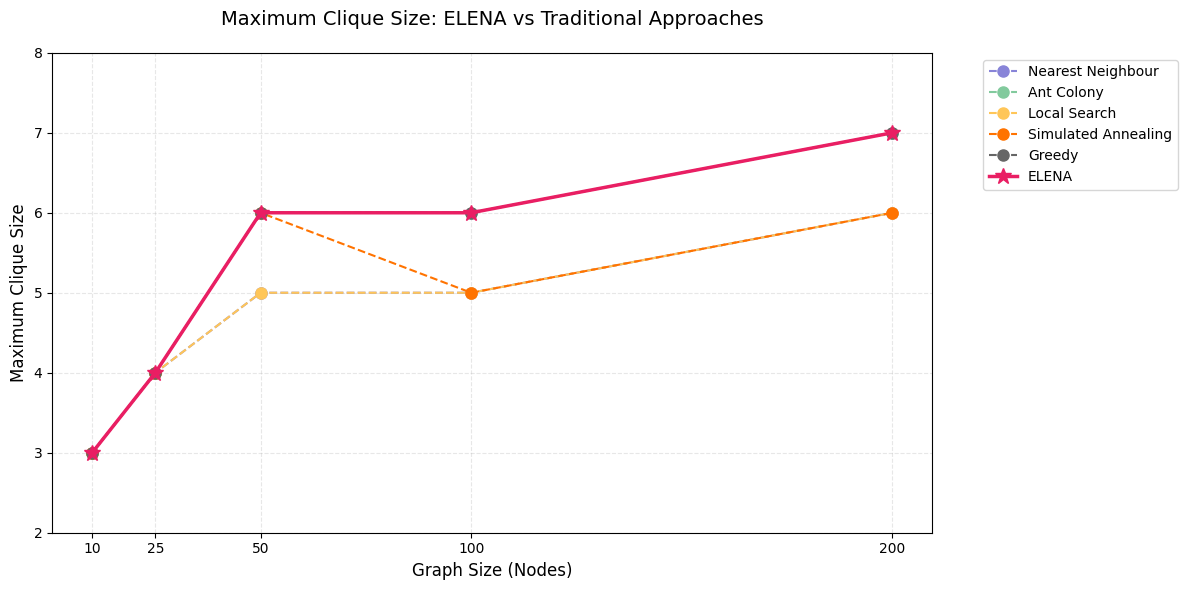


Generating population size impact visualization...


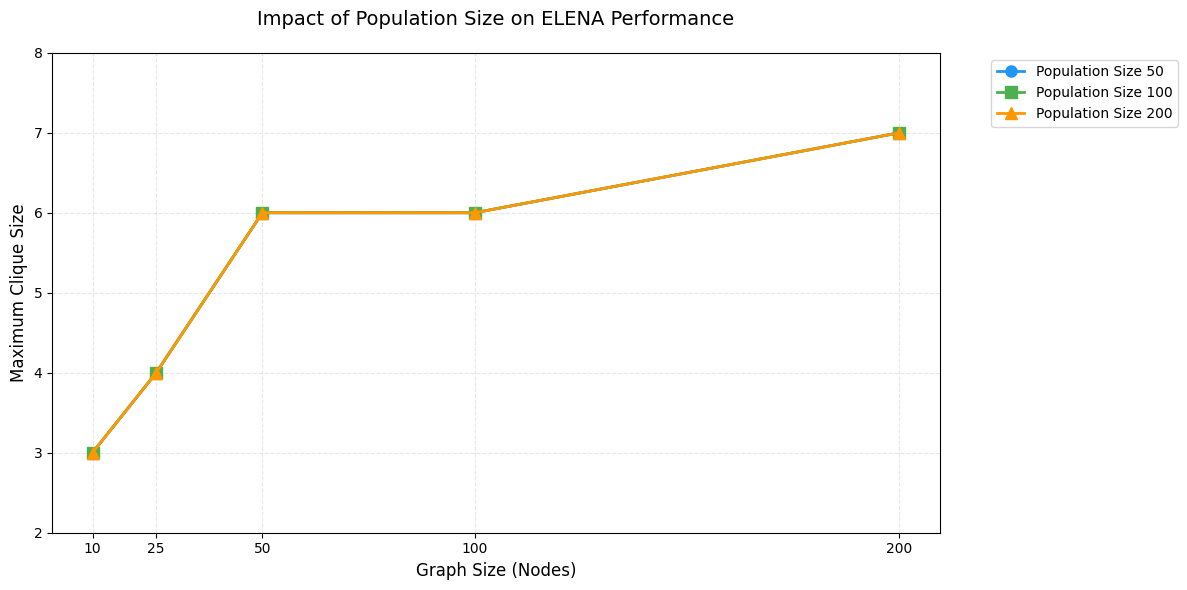

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# Create the performance data
evolutionary_data = {
    'Graph_Size': [10, 25, 50, 100, 200],
    'Evolutionary_50': [3, 4, 6, 6, 7],
    'Evolutionary_100': [3, 4, 6, 6, 7],
    'Evolutionary_200': [3, 4, 6, 6, 7]
}

traditional_data = {
    'Graph_Size': [10, 25, 50, 100, 200],
    'Nearest_Neighbour': [3, 4, 5, 5, 6],
    'Ant_Colony': [3, 4, 6, 6, 7],
    'Local_Search': [3, 4, 5, 5, 6],
    'Simulated_Annealing': [3, 4, 6, 5, 6],
    'Greedy': [3, 4, 6, 6, 7]
}

# Convert to DataFrames
df_evolutionary = pd.DataFrame(evolutionary_data)
df_traditional = pd.DataFrame(traditional_data)

def create_comparison_plot():
    """Create the comparison plot between ELENA and traditional approaches"""
    plt.figure(figsize=(12, 6))

    # Plot traditional approaches with distinct colors
    colors = ['#8884d8', '#82ca9d', '#ffc658', '#ff7300', '#666666']
    for i, algorithm in enumerate(['Nearest_Neighbour', 'Ant_Colony', 'Local_Search',
                                 'Simulated_Annealing', 'Greedy']):
        plt.plot(df_traditional['Graph_Size'], df_traditional[algorithm],
                marker='o', label=algorithm.replace('_', ' '),
                color=colors[i], linestyle='--', markersize=8)

    # Plot ELENA with emphasis
    plt.plot(df_evolutionary['Graph_Size'], df_evolutionary['Evolutionary_100'],
            marker='*', label='ELENA', linewidth=2.5, color='#e91e63',
            markersize=12)

    plt.title('Maximum Clique Size: ELENA vs Traditional Approaches',
              fontsize=14, pad=20)
    plt.xlabel('Graph Size (Nodes)', fontsize=12)
    plt.ylabel('Maximum Clique Size', fontsize=12)
    plt.xticks(df_evolutionary['Graph_Size'])
    plt.ylim(2, 8)

    # Add legend with better positioning
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

def create_population_comparison_plot():
    """Create the population size impact visualization"""
    plt.figure(figsize=(12, 6))

    colors = ['#2196f3', '#4caf50', '#ff9800']
    markers = ['o', 's', '^']

    for i, pop_size in enumerate(['Evolutionary_50', 'Evolutionary_100', 'Evolutionary_200']):
        plt.plot(df_evolutionary['Graph_Size'], df_evolutionary[pop_size],
                marker=markers[i],
                label=f'Population Size {pop_size.split("_")[1]}',
                color=colors[i], linewidth=2, markersize=8)

    plt.title('Impact of Population Size on ELENA Performance',
              fontsize=14, pad=20)
    plt.xlabel('Graph Size (Nodes)', fontsize=12)
    plt.ylabel('Maximum Clique Size', fontsize=12)
    plt.xticks(df_evolutionary['Graph_Size'])
    plt.ylim(2, 8)

    # Add legend with better positioning
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

# Generate both visualizations
print("Generating performance comparison visualization...")
create_comparison_plot()

print("\nGenerating population size impact visualization...")
create_population_comparison_plot()